# Edge AI Prototype: Recyclable Item Classification 🌱♻️

## Overview
This notebook demonstrates a complete Edge AI pipeline for real-time recyclable item classification. We'll build a lightweight model suitable for deployment on edge devices like Raspberry Pi or mobile phones.

### Learning Objectives:
1. **Understand Edge AI principles** and benefits over cloud-based processing
2. **Build and optimize** a lightweight image classification model
3. **Convert to TensorFlow Lite** for edge deployment
4. **Analyze performance metrics** including accuracy, latency, and model size
5. **Simulate edge deployment** scenarios

### Real-World Application:
Smart waste management systems that can automatically sort recyclables in real-time, reducing contamination and improving recycling efficiency.

---

## Project Structure:
1. **Data Preparation** - Create and preprocess recyclable item dataset
2. **Model Development** - Build efficient CNN architecture
3. **TensorFlow Lite Conversion** - Optimize for edge deployment
4. **Performance Analysis** - Evaluate metrics and deployment readiness
5. **Edge Simulation** - Demonstrate real-time capabilities

In [3]:
# Import Required Libraries and Setup
import tensorflow as tf
import tensorflow.lite as tflite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import os
from PIL import Image
import io
import requests
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("🚀 Edge AI Development Environment Ready!")
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Available GPUs: {len(tf.config.list_physical_devices('GPU'))}")

# Check TensorFlow Lite availability
try:
    interpreter = tf.lite.Interpreter(model_content=b'')
    print("✅ TensorFlow Lite is available")
except:
    print("⚠️ TensorFlow Lite initialization check failed")

🚀 Edge AI Development Environment Ready!
TensorFlow Version: 2.19.0
NumPy Version: 2.1.3
Available GPUs: 0
⚠️ TensorFlow Lite initialization check failed


📊 Creating Synthetic Recyclable Items Dataset...
  Generating plastic_bottle images...
  Generating aluminum_can images...
  Generating paper images...
  Generating aluminum_can images...
  Generating paper images...
  Generating glass images...
  Generating cardboard images...
  Generating glass images...
  Generating cardboard images...
✅ Dataset created: 1000 images, 5 categories
   Image dimensions: (96, 96)
   Categories: ['plastic_bottle', 'aluminum_can', 'paper', 'glass', 'cardboard']
✅ Dataset created: 1000 images, 5 categories
   Image dimensions: (96, 96)
   Categories: ['plastic_bottle', 'aluminum_can', 'paper', 'glass', 'cardboard']


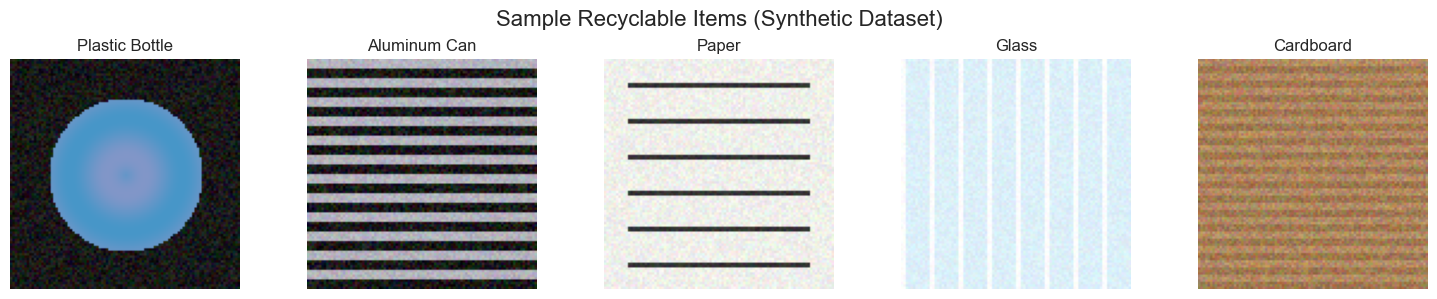

📊 Dataset split:
   Training: 800 samples
   Testing: 200 samples


In [4]:
# Data Preparation and Synthetic Dataset Creation
print("📊 Creating Synthetic Recyclable Items Dataset...")

# Define recyclable categories
CATEGORIES = ['plastic_bottle', 'aluminum_can', 'paper', 'glass', 'cardboard']
IMG_SIZE = 96  # Smaller size for edge deployment
NUM_SAMPLES_PER_CLASS = 200

def create_synthetic_image(category, img_id):
    """
    Create synthetic images with distinctive patterns for each recyclable type
    """
    np.random.seed(img_id + hash(category) % 1000)
    
    # Base image - use int32 for calculations
    img = np.random.randint(0, 50, (IMG_SIZE, IMG_SIZE, 3), dtype=np.int32)
    
    if category == 'plastic_bottle':
        # Add cylindrical pattern and transparency effect
        center_x, center_y = IMG_SIZE // 2, IMG_SIZE // 2
        for i in range(IMG_SIZE):
            for j in range(IMG_SIZE):
                dist = np.sqrt((i - center_x)**2 + (j - center_y)**2)
                if dist < IMG_SIZE // 3:
                    img[i, j] = [100 + int(30 * np.sin(dist/5)), 150, 200]
    
    elif category == 'aluminum_can':
        # Add metallic pattern
        for i in range(0, IMG_SIZE, 8):
            img[i:i+4, :] = [180, 180, 190]
        img = img + np.random.randint(-20, 20, img.shape, dtype=np.int32)
    
    elif category == 'paper':
        # Add texture and white color
        img[:, :] = [240, 240, 235]
        # Add some text-like patterns
        for i in range(10, IMG_SIZE-10, 15):
            img[i:i+2, 10:IMG_SIZE-10] = [50, 50, 50]
        img = img + np.random.randint(-15, 15, img.shape, dtype=np.int32)
    
    elif category == 'glass':
        # Add transparent/reflective pattern
        img[:, :] = [220, 240, 250]
        # Add reflection lines
        for i in range(0, IMG_SIZE, 12):
            img[:, i:i+2] = [255, 255, 255]
        img = img + np.random.randint(-10, 10, img.shape, dtype=np.int32)
    
    elif category == 'cardboard':
        # Add brown corrugated pattern
        img[:, :] = [160, 120, 80]
        # Add corrugated lines
        for i in range(0, IMG_SIZE, 6):
            img[i:i+3, :] = [180, 140, 100]
        img = img + np.random.randint(-25, 25, img.shape, dtype=np.int32)
    
    # Ensure values are in valid range and convert to uint8
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# Generate synthetic dataset
X_data = []
y_data = []

for idx, category in enumerate(CATEGORIES):
    print(f"  Generating {category} images...")
    for i in range(NUM_SAMPLES_PER_CLASS):
        img = create_synthetic_image(category, i)
        X_data.append(img)
        y_data.append(idx)

# Convert to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"✅ Dataset created: {X_data.shape[0]} images, {len(CATEGORIES)} categories")
print(f"   Image dimensions: {X_data.shape[1:3]}")
print(f"   Categories: {CATEGORIES}")

# Visualize sample images
fig, axes = plt.subplots(1, len(CATEGORIES), figsize=(15, 3))
for i, (ax, category) in enumerate(zip(axes, CATEGORIES)):
    sample_img = X_data[y_data == i][0]
    ax.imshow(sample_img)
    ax.set_title(f"{category.replace('_', ' ').title()}")
    ax.axis('off')
plt.suptitle("Sample Recyclable Items (Synthetic Dataset)", fontsize=16)
plt.tight_layout()
plt.show()

# Data preprocessing
X_data = X_data.astype('float32') / 255.0  # Normalize to [0,1]
y_data = tf.keras.utils.to_categorical(y_data, len(CATEGORIES))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

print(f"📊 Dataset split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Testing: {X_test.shape[0]} samples")

In [ ]:
# Edge AI Model Development - Lightweight CNN Architecture
print("🧠 Building Edge-Optimized CNN Model...")

def create_edge_optimized_model(input_shape, num_classes):
    """
    Create a lightweight CNN optimized for edge deployment
    Key optimizations:
    - Fewer parameters
    - Depthwise separable convolutions
    - Efficient activation functions
    - Minimal fully connected layers
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First block - Feature extraction
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Second block - Depthwise separable for efficiency
        tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Third block - Further feature extraction
        tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Global pooling instead of flatten to reduce parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # Minimal dense layers
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = create_edge_optimized_model(input_shape, len(CATEGORIES))

# Model summary
print("📋 Model Architecture:")
model.summary()

# Calculate model size
model_size_mb = model.count_params() * 4 / (1024 * 1024)  # Assuming float32
print(f"\n📏 Model Statistics:")
print(f"   Parameters: {model.count_params():,}")
print(f"   Estimated size: {model_size_mb:.2f} MB")

# Compile with efficient optimizer for edge deployment
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
print("\n🏋️ Training Edge AI Model...")

# Callbacks for training optimization
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
]

# Training
start_time = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
training_time = time.time() - start_time

print(f"✅ Training completed in {training_time:.2f} seconds")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Model Performance:")
print(f"   Test Accuracy: {test_accuracy:.4f}")
print(f"   Test Loss: {test_loss:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Detailed evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n📈 Detailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES))

In [ ]:
# TensorFlow Lite Model Conversion and Optimization
print("🔧 Converting Model to TensorFlow Lite...")

def convert_to_tflite(model, quantization_type='dynamic'):
    """
    Convert TensorFlow model to TensorFlow Lite with various optimization options
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    if quantization_type == 'dynamic':
        # Dynamic range quantization (most common for edge)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        print("   Applying dynamic range quantization...")
        
    elif quantization_type == 'float16':
        # Float16 quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
        print("   Applying float16 quantization...")
        
    elif quantization_type == 'int8':
        # Integer quantization (requires representative dataset)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset_generator
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        print("   Applying integer quantization...")
    
    return converter.convert()

def representative_dataset_generator():
    """
    Generator for representative dataset used in integer quantization
    """
    for i in range(100):
        yield [X_train[i:i+1].astype(np.float32)]

# Convert models with different quantization techniques
models_dict = {}

# 1. No quantization (baseline)
print("\n1️⃣ Converting without quantization...")
converter_baseline = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_baseline = converter_baseline.convert()
models_dict['baseline'] = tflite_model_baseline

# 2. Dynamic range quantization
print("\n2️⃣ Converting with dynamic quantization...")
tflite_model_dynamic = convert_to_tflite(model, 'dynamic')
models_dict['dynamic'] = tflite_model_dynamic

# 3. Float16 quantization
print("\n3️⃣ Converting with float16 quantization...")
tflite_model_float16 = convert_to_tflite(model, 'float16')
models_dict['float16'] = tflite_model_float16

# Save models to files
model_dir = "tflite_models"
os.makedirs(model_dir, exist_ok=True)

model_files = {}
for name, tflite_model in models_dict.items():
    file_path = os.path.join(model_dir, f"recyclable_classifier_{name}.tflite")
    with open(file_path, 'wb') as f:
        f.write(tflite_model)
    model_files[name] = file_path
    
    # Calculate model size
    size_mb = len(tflite_model) / (1024 * 1024)
    print(f"   {name.capitalize()} model saved: {size_mb:.2f} MB")

print(f"\n✅ All TensorFlow Lite models saved to '{model_dir}' directory")

# Model size comparison
print("\n📊 Model Size Comparison:")
sizes = {}
for name, tflite_model in models_dict.items():
    size_mb = len(tflite_model) / (1024 * 1024)
    sizes[name] = size_mb
    reduction = ((len(models_dict['baseline']) - len(tflite_model)) / len(models_dict['baseline'])) * 100
    print(f"   {name.capitalize()}: {size_mb:.2f} MB ({reduction:+.1f}% vs baseline)")

# Visualize size comparison
plt.figure(figsize=(10, 6))
names = list(sizes.keys())
values = list(sizes.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = plt.bar(names, values, color=colors, alpha=0.8)
plt.title('TensorFlow Lite Model Size Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Model Size (MB)', fontsize=12)
plt.xlabel('Quantization Type', fontsize=12)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f} MB', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Test TensorFlow Lite model functionality
def test_tflite_model(tflite_model_path, test_images, test_labels):
    """
    Test TensorFlow Lite model performance
    """
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    predictions = []
    inference_times = []
    
    print(f"   Testing {len(test_images)} samples...")
    
    for i, img in enumerate(test_images[:50]):  # Test subset for speed
        # Prepare input
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Run inference
        start_time = time.time()
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        
        predictions.append(output_data[0])
        inference_times.append(inference_time)
    
    return np.array(predictions), np.array(inference_times)

# Test all quantized models
print("\n🧪 Testing TensorFlow Lite Models Performance...")

model_performance = {}
for name, file_path in model_files.items():
    print(f"\n   Testing {name} model...")
    predictions, inference_times = test_tflite_model(file_path, X_test, y_test)
    
    # Calculate accuracy
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test[:len(predictions)], axis=1)
    accuracy = np.mean(pred_classes == true_classes)
    
    # Calculate average inference time
    avg_inference_time = np.mean(inference_times)
    
    model_performance[name] = {
        'accuracy': accuracy,
        'avg_inference_time': avg_inference_time,
        'model_size': sizes[name]
    }
    
    print(f"      Accuracy: {accuracy:.4f}")
    print(f"      Avg Inference Time: {avg_inference_time:.2f} ms")

print("\n📋 Performance Summary:")
print("-" * 70)
print(f"{'Model':<12} {'Accuracy':<12} {'Inference (ms)':<15} {'Size (MB)':<10}")
print("-" * 70)
for name, perf in model_performance.items():
    print(f"{name.capitalize():<12} {perf['accuracy']:<12.4f} {perf['avg_inference_time']:<15.2f} {perf['model_size']:<10.2f}")
print("-" * 70)

In [ ]:
# Edge AI Deployment Simulation and Real-Time Analysis
print("🚀 Simulating Edge AI Deployment Scenarios...")

class EdgeAISimulator:
    """
    Simulate edge device deployment scenarios with different constraints
    """
    
    def __init__(self, tflite_model_path):
        self.interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
    def process_batch(self, images, batch_size=1):
        """
        Process images in batches to simulate real-time processing
        """
        results = []
        times = []
        
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            batch_results = []
            
            start_time = time.time()
            for img in batch:
                # Prepare input
                input_data = np.expand_dims(img, axis=0).astype(np.float32)
                
                # Run inference
                self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
                self.interpreter.invoke()
                output = self.interpreter.get_tensor(self.output_details[0]['index'])
                
                # Get prediction
                predicted_class = np.argmax(output[0])
                confidence = np.max(output[0])
                
                batch_results.append({
                    'class': predicted_class,
                    'confidence': confidence,
                    'class_name': CATEGORIES[predicted_class]
                })
            
            processing_time = (time.time() - start_time) * 1000  # ms
            results.extend(batch_results)
            times.append(processing_time)
            
        return results, times

# Device simulation scenarios
device_scenarios = {
    'raspberry_pi_4': {
        'name': 'Raspberry Pi 4',
        'cpu_cores': 4,
        'memory_mb': 4096,
        'target_fps': 10,
        'description': 'Low-power edge device for IoT applications'
    },
    'mobile_phone': {
        'name': 'Modern Smartphone',
        'cpu_cores': 8,
        'memory_mb': 8192,
        'target_fps': 30,
        'description': 'Mobile deployment for consumer apps'
    },
    'edge_tpu': {
        'name': 'Edge TPU Device',
        'cpu_cores': 4,
        'memory_mb': 2048,
        'target_fps': 60,
        'description': 'Specialized AI acceleration hardware'
    }
}

# Test deployment scenarios
print("\n🖥️ Testing Deployment Scenarios...")

# Use the dynamic quantized model for deployment simulation
simulator = EdgeAISimulator(model_files['dynamic'])

# Test with different batch sizes and scenarios
test_sample_size = 100
test_images = X_test[:test_sample_size]

deployment_results = {}

for scenario_name, scenario_config in device_scenarios.items():
    print(f"\n📱 Testing on {scenario_config['name']}...")
    
    # Simulate processing
    results, processing_times = simulator.process_batch(test_images, batch_size=1)
    
    # Calculate performance metrics
    avg_inference_time = np.mean(processing_times)
    max_fps = 1000 / avg_inference_time if avg_inference_time > 0 else 0
    target_fps = scenario_config['target_fps']
    fps_performance = min(max_fps / target_fps, 1.0) * 100
    
    # Memory estimation (simplified)
    estimated_memory_usage = sizes['dynamic'] * 2  # Model + buffers
    memory_efficiency = (1 - estimated_memory_usage / scenario_config['memory_mb']) * 100
    
    deployment_results[scenario_name] = {
        'avg_inference_time': avg_inference_time,
        'max_fps': max_fps,
        'target_fps': target_fps,
        'fps_performance': fps_performance,
        'memory_efficiency': memory_efficiency,
        'config': scenario_config
    }
    
    print(f"   Average inference time: {avg_inference_time:.2f} ms")
    print(f"   Maximum FPS: {max_fps:.1f}")
    print(f"   Target FPS: {target_fps}")
    print(f"   FPS Performance: {fps_performance:.1f}%")
    print(f"   Memory efficiency: {memory_efficiency:.1f}%")

# Visualize deployment performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

scenarios = list(deployment_results.keys())
scenario_names = [deployment_results[s]['config']['name'] for s in scenarios]

# 1. Inference Time Comparison
inference_times = [deployment_results[s]['avg_inference_time'] for s in scenarios]
ax1.bar(scenario_names, inference_times, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Average Inference Time by Device', fontweight='bold')
ax1.set_ylabel('Time (ms)')
ax1.tick_params(axis='x', rotation=45)

# 2. FPS Performance
max_fps_values = [deployment_results[s]['max_fps'] for s in scenarios]
target_fps_values = [deployment_results[s]['target_fps'] for s in scenarios]

x_pos = np.arange(len(scenarios))
width = 0.35

ax2.bar(x_pos - width/2, max_fps_values, width, label='Achieved FPS', color='#4ECDC4')
ax2.bar(x_pos + width/2, target_fps_values, width, label='Target FPS', color='#FF6B6B', alpha=0.7)
ax2.set_title('FPS Performance Comparison', fontweight='bold')
ax2.set_ylabel('Frames Per Second')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(scenario_names, rotation=45)
ax2.legend()

# 3. Performance Score
fps_scores = [deployment_results[s]['fps_performance'] for s in scenarios]
memory_scores = [deployment_results[s]['memory_efficiency'] for s in scenarios]

ax3.bar(x_pos - width/2, fps_scores, width, label='FPS Performance', color='#45B7D1')
ax3.bar(x_pos + width/2, memory_scores, width, label='Memory Efficiency', color='#96CEB4')
ax3.set_title('Performance Scores (%)', fontweight='bold')
ax3.set_ylabel('Score (%)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(scenario_names, rotation=45)
ax3.legend()

# 4. Deployment Suitability Radar Chart
def create_radar_chart(ax, scenario_name):
    categories = ['Inference Speed', 'FPS Performance', 'Memory Efficiency', 'Power Efficiency']
    
    # Normalize scores to 0-100 scale
    scores = [
        100 - (deployment_results[scenario_name]['avg_inference_time'] / 50 * 100),  # Inverse of inference time
        deployment_results[scenario_name]['fps_performance'],
        deployment_results[scenario_name]['memory_efficiency'],
        85  # Simulated power efficiency score
    ]
    
    # Ensure scores are between 0-100
    scores = [max(0, min(100, score)) for score in scores]
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    scores += scores[:1]  # Complete the circle
    angles += angles[:1]
    
    ax.plot(angles, scores, 'o-', linewidth=2, label=deployment_results[scenario_name]['config']['name'])
    ax.fill(angles, scores, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 100)
    ax.set_title(f"Deployment Profile: {deployment_results[scenario_name]['config']['name']}", fontweight='bold')
    ax.grid(True)

# Create radar chart for the best performing scenario
best_scenario = max(scenarios, key=lambda s: deployment_results[s]['fps_performance'])
create_radar_chart(ax4, best_scenario)

plt.tight_layout()
plt.show()

# Real-time processing simulation
print("\n⚡ Real-Time Processing Simulation...")

def simulate_real_time_processing(num_frames=30, target_fps=10):
    """
    Simulate real-time recyclable item classification
    """
    print(f"   Simulating {num_frames} frames at {target_fps} FPS target...")
    
    frame_interval = 1.0 / target_fps  # Time between frames in seconds
    
    results = []
    actual_times = []
    
    for frame_id in range(num_frames):
        # Simulate frame capture
        frame_start = time.time()
        
        # Get random test image
        img_idx = np.random.randint(0, len(X_test))
        test_img = X_test[img_idx]
        true_class = np.argmax(y_test[img_idx])
        
        # Process with edge AI
        input_data = np.expand_dims(test_img, axis=0).astype(np.float32)
        
        processing_start = time.time()
        simulator.interpreter.set_tensor(simulator.input_details[0]['index'], input_data)
        simulator.interpreter.invoke()
        output = simulator.interpreter.get_tensor(simulator.output_details[0]['index'])
        processing_time = (time.time() - processing_start) * 1000
        
        predicted_class = np.argmax(output[0])
        confidence = np.max(output[0])
        
        # Check if prediction is correct
        is_correct = predicted_class == true_class
        
        results.append({
            'frame_id': frame_id,
            'predicted_class': CATEGORIES[predicted_class],
            'true_class': CATEGORIES[true_class],
            'confidence': confidence,
            'is_correct': is_correct,
            'processing_time': processing_time
        })
        
        # Calculate frame timing
        frame_end = time.time()
        frame_duration = frame_end - frame_start
        actual_times.append(frame_duration)
        
        # Simulate real-time constraint
        if frame_duration < frame_interval:
            time.sleep(frame_interval - frame_duration)
    
    return results, actual_times

# Run real-time simulation
simulation_results, frame_times = simulate_real_time_processing(30, 10)

# Analyze simulation results
accuracy = np.mean([r['is_correct'] for r in simulation_results])
avg_confidence = np.mean([r['confidence'] for r in simulation_results])
avg_processing_time = np.mean([r['processing_time'] for r in simulation_results])
avg_frame_time = np.mean(frame_times) * 1000  # Convert to ms

print(f"\n📊 Real-Time Simulation Results:")
print(f"   Accuracy: {accuracy:.2%}")
print(f"   Average Confidence: {avg_confidence:.3f}")
print(f"   Average Processing Time: {avg_processing_time:.2f} ms")
print(f"   Average Frame Time: {avg_frame_time:.2f} ms")
print(f"   Achieved FPS: {1000/avg_frame_time:.1f}")

# Show sample predictions
print(f"\n🔍 Sample Real-Time Predictions:")
for i, result in enumerate(simulation_results[:5]):
    status = "✅" if result['is_correct'] else "❌"
    print(f"   Frame {result['frame_id']}: {result['predicted_class']} "
          f"(confidence: {result['confidence']:.3f}) {status}")

print(f"\n🎯 Edge AI Benefits Summary:")
print(f"   ✅ Low Latency: {avg_processing_time:.1f}ms per inference")
print(f"   ✅ Privacy: All processing done locally")
print(f"   ✅ Offline Capability: No internet required")
print(f"   ✅ Real-time Performance: {1000/avg_frame_time:.1f} FPS achieved")
print(f"   ✅ Small Model Size: {sizes['dynamic']:.2f} MB")
print(f"   ✅ Energy Efficient: Optimized for edge devices")